In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
from sklearn import datasets, linear_model
import copy as cp
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D

import numpy.random as randn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import Lasso

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
import copy 

from scipy.integrate import quad
import scipy.stats
from sklearn import datasets, linear_model

# Régression probabiliste

## Résumé

La **régression** est un processus d'apprentissage supervisé qui consiste à construire un modèle prédictif à partir de données quantitatives.

On considère un observation $X$ (pouvant être vectoriel) et une sortie $y$ scalaire ici (mais pouvant être vectoriel) tel que

$$
y=f(X)+ \epsilon
$$

avec une fonction (transformation) inconnue et $\epsilon$ un bruit sur les données.

**But**: $\color{red}{\text{approcher $f$ à partir d'un jeu d'apprentissage $((X_1,y_1),....,(X_n,y_n))$}}$.

**Modèle Paramétrique**:

On se donne une fonction $f_{\theta}$ connue mais dépendante de paramètres (nombres) **inconnus**.

En $\color{red}{\text{apprentissage supervisé}}$ on va trouver les **paramètres $\theta$** tel que $f_{\theta}(X)$ $\color{red}{\text{prédit au mieux le $y$ associé à $x$}}$.

$\theta$ peut prendre plein de valeur possible donc il existe beaucoup de modèles possibles.

Ici on considère que $f_{\theta}(X)$ par rapport à $X$

Cas général:
- si $X=x$ est un nombre
$$
f_{\theta}(x)=\omega x + b
$$

avec $\theta=(\omega,b)$ les paramètres à déterminer.
- si $X=(x_1,...x_d)$ est un vecteur en taille $d$
$$
f_{\theta}(X)=\sum_{i=1}^d \omega_i x_i + b
$$

avec $\theta=(\omega_1,...\omega_d,b)$ les paramètres à déterminer.

**Exemple**: On cherche à comprendre comment des facteurs de risques influent sur le poids du bébé à la naissance.

On propose comme facteur explicatifs:
- l'âge de la mère,
- la poids de la mère,
- consommation d'alcool en verre par semaine (de 0 à 20),
- tabagisme en cigarette par semaine (de 0 à 50).

On propose le modèle suivant:
    
$$
PBEBE= a_0 + a_1 PMERE + a_2 AGE + a_3 ALCOOL + a_4 TABAC + \epsilon
$$

Si on détermine $(a_0,a_1,a_2,a_3,a_4)$ qui explique bien $PBEBE$ on pourra déterminer le facteur principal. Celui dont le paramètre $a_i$ sera le plus grand.

Pour déterminer les paramètres, on souhaite résoudre

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n d_2(y_i,f_{\theta}(X_i))^2
$$

avec $d_2(y_1,y_2)$ une distance entre 2 nombres.

- pour $d=1$ cela revient à trouver la droite qui minimise la distance aux points $y$ du jeux d'apprentissage,
- pour $d=2$ cela revient à trouver le plan qui minimise la distance aux points $y$ du jeux d'apprentissage.

On appelle $\color{red}{\text{$J$ la fonction coût ou la "loss"}}$.

### Régression et malediction en grande dimension

**Résultat théorique**:
- $N>d+1$  on a unicité du $\theta=(\omega,b)$ qui minimise l'erreur,
- $N=d+1$  on a unicité du $\theta=(\omega,b)$ qui minimise l'erreur et on passe exactement par les exemples,
- $d+1>N$   on a pas unicité du $\theta=(\omega,b)$ qui minimise l'erreur, et on passe exactement par les points. $\color{red}{\text{Il existe donc une infinité de modèles possibles dont le bon}}$.

**Mais**: *Par contre si $N>>d+1$ et si il y a du bruit on apprend peu le bruit*.

In [12]:
def generate_data(sigma,beta,alpha,n,m): ## génère n exemple dans R^m avec le modèle $f$
    X = np.zeros((n,m)) ## creation de la matrice à n exemple de dimension m
    Y = np.zeros(n) ## creation de la matrice à n exemple de dimension l
    Xhat = np.zeros((n,m)) ## creation de la matrice à n exemple de dimension m
    Yhat = np.zeros(n)
    eps = randn.normal(0.0,sigma,n) ## vecteur des bruits
    meanY = 0.0
    meanX = np.zeros(m)
    varianceX = np.zeros(m)
    for i in range(0, n):
        X[i,:]=randn.uniform(0.0,2.0,m) # m nombre aléatoire entre 0 et 1
        Y[i]= np.dot(beta,X[i,:])+alpha+eps[i]
        meanX[:] = meanX + X[i,:]/n
        meanY = meanY + Y[i]/n 
        varianceX[:] = varianceX[:] + X[i,:]*X[i,:]/n
        
    for i in range(0, n):
        Xhat[i,:]= (X[i,:]-meanX[:])/(varianceX[:])
        Yhat[i]= (Y[i]-meanY)
    
    return X,Y,eps

In [13]:
# calcul les erreur pour la regression Rdige
def errorR(lam,beta_hat,alpha_hat,X,Y,n,m):
    nnew=100
    if lam >0:
        reg = Ridge(alpha=lam,tol=10-12,solver='svd').fit(X,Y)
    else: 
        reg = LinearRegression().fit(X, Y)
     
    Yref = np.zeros(n); Ycom = np.zeros(n)   
    Ynewref = np.zeros(nnew); Ynewcom = np.zeros(nnew)
       
    Xnew = np.zeros((nnew,m)) # entrées et sortiesde l'échantillon de test
    for i in range(0, nnew):
        Xnew[i,:]=randn.uniform(0.0,2.0,m)   
        Ynewref[i]= np.dot(beta_hat,Xnew[i,:])+alpha_hat
        Ynewcom[i] = np.dot(reg.coef_,Xnew[i,:])+reg.intercept_

    for i in range(0, n): # sortie de l'échantillon d'entrainement
        Ycom[i] = np.dot(reg.coef_,X[i,:])+reg.intercept_
        Yref[i]= np.dot(beta_hat,X[i,:])+alpha_hat

    Error=0.0;  ErrorQuad=0.0; normp=0.0

    Error = np.mean((Ynewref - Ynewcom)**2)
    ErrorQuad = np.mean((Y - Ycom)**2) 

    normp = reg.intercept_**2
    for i in range(0,m):
        normp = normp+reg.coef_[i]**2
    normp/(m+1) 
    return Error,ErrorQuad,normp

In [14]:
def plot_overfitting_dim(bruit,dim): ## affiche les erreurs pour une regréssion classique
    n = 100 
    EQ=[]; E=[]; B=[]; V=[]; iterl=[] ## liste de stockage
    for m in range(10,dim,5):
        beta= randn.uniform(-1.0,1.0,m)
        alpha = randn.uniform(-1.0,1.0)
        X,Y,eps= generate_data(bruit,beta,alpha,n,m)
        Error,ErrorQuad,normp = errorR(0.0,beta,alpha,X,Y,n,m)
        E.append(Error); EQ.append(ErrorQuad); iterl.append(m)

    fig = make_subplots(rows=1, cols=2) 
    fig.add_trace(go.Scatter(x=iterl, y=E,line_width=3,line_color='blue'), row=1, col=1)
    fig.update_layout(
        title_text="Erreur sur nouvelles données"          
    )
    if dim>100:
        fig.add_vline(x=100,line_color='red')

    fig.add_trace(go.Scatter(x=iterl, y=EQ,line_width=3,line_color="blue"), row=1, col=2)
    if dim>100:
        fig.add_vline(x=100,line_color='red')
    fig.update_layout(height=300, width=900, margin=dict(l=35, r=30, b=45, t=60),showlegend=False)
    fig.show()

**Exemple en grande dimension**.

$$
y=f(X)+\epsilon 
$$

avec $f(X)=\sum_{i=1}^d \alpha_i x_i + \beta$ et $(\alpha_1,....,\alpha_d)$ choisis aléatoirement. On l'approche avec

$$
f_{\theta}(X)=\sum_{i=1}^d \omega_i x_i + b
$$

**Régression avec N=100 exemples**. On fait varier $d$ la taille de $X$. 
- Gauche: erreur sur les données exemples (données d'apprentissage),
- Droite: erreur sur de nouvelles données

In [15]:
@interact(bruit=(0.02,0.05,0.005),dim=(20,400,10))
def plot7(bruit=0.05,dim=20):
    plot_overfitting_dim(bruit,dim)

interactive(children=(FloatSlider(value=0.05, description='bruit', max=0.05, min=0.02, step=0.005), IntSlider(…

**Modèle généraux**: si un modèle est trop complexe, a trop de paramètres par rapport aux nombres d'exemples, l'apprentissage peut échouer. Pour les problèmes linéaires cela vient d'une perte d'unicité.

Dans ce cas, il existe beaucoup de jeux de paramètres qui modélisent parfaitement les exemples, y compris de très mauvais jeux de paramètres.

En général le problème ne vient pas d'une perte d'unicité, comme pour les modèles linéaires. En effet il y a rarement unicité dans la vraie vie mais plein de bon jeux de paramètres (proche du bon).


$\color{red}{\text{Mais si le nombre de paramètres devient trop grand ou les modèle trop riches}}$:

- on peut bien apprendre les données mais quand même tombé sur un mauvais jeu de paramètres.
- on apprend tellement bien les données qu'on apprend le bruit.
- on apprend tellement bien les données qu'on apprend les défauts du jeux d'apprentissage (surreprésentation de certaines données etc).

### Régularisation

Comment régler le sur-apprentissage ?

On a vu qu'il apparaissait quand:
- le nombre de paramètres est trop grand,
- le modèle est trop complexe.

Dans les deux cas: **trop de liberté laisser au modèle** qui capture très bien les données au risque de pas savoir généraliser

**Solution**: $\color{red}{\text{contraindre le modèle à être plus simple ou contraindre les paramètres}}$.

### Régression Ridge

La première solution est appelée **Régression Ridge**.

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n d_2(y_i,f_{\theta}(x_i))^2 +\lambda d_2(\theta,0)^2
$$

On contraint un peu les poids a être proche de zéro. Dans ce cas:
- il y a unicité de la solution 
- la solution s'éloigne de la vrai solution lorsque $\lambda>0$


**Régression Lasso**:

On résout

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n d_2(y_i,f_{\theta}(x_i))^2 +\lambda d_1(\theta,0)^2
$$

avec $d_1(.,.)$ la distance de Manhattan.

Ici cela ne contraint pas les paramètres à être petit mais cela contraint un certain nombre de paramètres à être nul. Plus $\lambda$ est grand plus un nombre important de paramètres sont nuls.

**Hypothèse de Parcimonie**:

on a $f(x)=\sum_{i=1}^d a_i x_i+a_0$ avec $d>>1$.

$f(x)$ est parcimonieuse si beaucoup de coefficients $a_i$  sont nuls.

La $\color{red}{\text{régression Lasso permet de pouvoir capturer ce genre de fonction}}$ la ou une régression ridge va chercher un bon modèle sans mettre les coefficients à zéro.

## Probabilité

Un loi de probabilité est un ensemble de valeur qui décrit les probabilités qu'un objet aléatoire peut prendre comme valeur. 

$\color{red}{\text{Les probabilités sont toujours données entre 0 et 1}}$.

- Exemple: Pile/Face

$$
\mbox{Valeurs}: [P, F] 
$$

Loi de probabilité sur la piece "P_i"

$$
P(P_i=F)=0.5, \quad P(P_i=P)=0.5
$$

- Exemple: Dé

$$
\mbox{Valeurs}: [1, 2, 3, 4, 5, 6] 
$$

Loi de probabilité sur la piece "D_e"

$$
P(D_e=1)=0.166666666, \quad P(D_e=2)=0.166666666
$$

etc

**loi de probabilité continue**: l'objet aléatoire peut prendre n'importe quelles valeurs dans un intervalle $[a,b]$.

**Exemple**: On part d'un endroit au temps $t$. On peut regarder $X$ la probabilité que le temps d'arrivée soit entre $[t_1,t_2]$

Si on considère qu'on peut avoir une précision arbitraire sur la mesure du temps (seconde, milliseconde, nanoseconde, etc), la probabilité $P(X=t)=0$.

On regarde souvent des probabilités du type $P(X \in [t-\epsilon,t+\epsilon])$

**Exemple de distributions discrètes**:

- **Loi de Bernoulli**: modélise, un phénomène aléatoire a deux valeurs possibles (Pile, Face) par exemple.

$$
P(X=1)=p, \quad P(X=0)=1-p
$$

- **Loi de binomiale**: modélise la fréquence du nombre de succès obtenus lors de la répétition de plusieurs expériences aléatoires identiques et indépendantes

- **Loi de Poisson**: etc 

In [16]:
def plot_binomial(p): 
# Normal Distribution

    fig = make_subplots(rows=1, cols=1) 
    xx = np.arange(scipy.stats.binom.ppf(0.00000000001, 100, p),scipy.stats.binom.ppf(0.99999999999, 100, p))
    rv = scipy.stats.binom(100, p)
    fig.add_trace(go.Scatter(
        x=xx,
        y=rv.pmf(xx),mode='markers',line_color='red'))

    for i in range(0,len(rv.pmf(xx))):
        fig.add_shape(type="line",
            x0=xx[i], y0=0.0, x1=xx[i], y1=rv.pmf(xx)[i],
            line=dict(
            color="red",
            width=2)
        )
    fig.show()

In [17]:
@interact(p=(0.1,0.9,0.05))
def plotp1(p):
    plot_binomial(p)

interactive(children=(FloatSlider(value=0.5, description='p', max=0.9, min=0.1, step=0.05), Output()), _dom_cl…

In [18]:
def plot_poisson(mu): 
# Normal Distribution

    fig = make_subplots(rows=1, cols=1) 
    xx = np.arange(scipy.stats.poisson.ppf(0.00000001, mu),scipy.stats.poisson.ppf(0.99999999, mu))
    rv = scipy.stats.poisson(mu)
    
    fig.add_trace(go.Scatter(
        x=xx,
        y=rv.pmf(xx),mode='markers',line_color='red'))

    for i in range(0,len(rv.pmf(xx))):
        fig.add_shape(type="line",
            x0=xx[i], y0=0.0, x1=xx[i], y1=rv.pmf(xx)[i],
            line=dict(
            color="red",
            width=2)
        )
    fig.show()

In [19]:
@interact(mu=(0.1,10,0.5))
def plotp2(mu):
    plot_poisson(mu)

interactive(children=(FloatSlider(value=4.6, description='mu', max=10.0, min=0.1, step=0.5), Output()), _dom_c…

**Exemple de distribution continues**:

- **Loi Gaussienne**: maximale et symétrique autour de la moyenne. Donc les écarts à la moyenne de même amplitude ont la même probabilité. Très utilisée pour modéliser une erreur/un bruit. On note

$$
\mathcal{N}(\mu,\sigma^2)
$$

Une gaussienne de moyenne $\mu$ et tel que 95% des valeurs possibles soit dans $[-\sigma,\sigma]$.
**Ecart type**: $\sigma$, **Variance**: $\sigma^2$.

- **Loi uniforme**: toutes les valeurs ont la même probabilité.

- **Loi de Laplace, Gamma etc**.

In [20]:
def plot_gaussienne(mean,std,x1,x2): 
# Normal Distribution
    x_min = -4.0
    x_max = 4.0

    x = np.linspace(x_min, x_max, 800)
    y = scipy.stats.norm.pdf(x,mean,std)
    fig = make_subplots(rows=1, cols=1) 
    fig.add_trace(go.Scatter(x=x, y=y,line_width=3,line_color='black'), row=1, col=1)
    
    normal = lambda x : scipy.stats.norm.pdf(x,mean,std)
    res, err = quad(normal, x1, x2,)

    ptx = np.linspace(x1, x2, 800)
    pty = scipy.stats.norm.pdf(ptx,mean,std)
    fig.add_trace(go.Scatter(x=ptx, y=pty, fill='tozeroy',
                    mode='none' # override default markers+lines
                    ))
    fig.add_trace(go.Scatter(
        x=[0.5*(x1+x2)],
        y=[0.5*scipy.stats.norm.pdf(0.5*(x1+x2),std)],
        mode="lines+text",
        text=["P(x1<x<x2) = {0:5.2f}".format(res)],
        textposition="bottom center")
    )
    fig.add_vline(x=x1,line_color='red')
    fig.add_vline(x=x2,line_color='red')
    fig.show()

In [21]:
@interact(mean=(-2.0,2.0,0.2),std=(0.01,1.0,0.01),x1=(-4.0,4.0,0.5),x2=(-4.0,4.0,0.5))
def plotp3(mean=0.0,std=0.5,x1=0.0,x2=0.2):
    plot_gaussienne(mean,std,x1,x2)

interactive(children=(FloatSlider(value=0.0, description='mean', max=2.0, min=-2.0, step=0.2), FloatSlider(val…

In [10]:
def plot_laplace(alpha,x1,x2): 
# Normal Distribution
    x_min = -4.0
    x_max = 4.0

    x = np.linspace(x_min, x_max, 1550)
    y = scipy.stats.laplace.pdf(x,alpha)
    fig = make_subplots(rows=1, cols=1) 
    fig.add_trace(go.Scatter(x=x, y=y,line_width=3,line_color='black'), row=1, col=1)
    
    loi = lambda x : scipy.stats.laplace.pdf(x,alpha)
    res, err = quad(loi, x1, x2)

    ptx = np.linspace(x1, x2, 800)
    pty = scipy.stats.laplace.pdf(ptx,alpha)
    fig.add_trace(go.Scatter(x=ptx, y=pty, fill='tozeroy',
                    mode='none' # override default markers+lines
                    ))
    fig.add_trace(go.Scatter(
        x=[0.5*(x1+x2)],
        y=[0.5*scipy.stats.laplace.pdf(0.5*(x1+x2),alpha)],
        mode="lines+text",
        text=["P(x1<x<x2) = {0:5.2f}".format(res)],
        textposition="bottom center")
    )
    fig.add_vline(x=x1,line_color='red')
    fig.add_vline(x=x2,line_color='red')
    fig.show()

In [22]:
@interact(alpha=(-2.0,2.0,0.2),x1=(-4.0,4.0,0.5),x2=(-4.0,4.0,0.5))
def plotp4(alpha=0.0,x1=0.0,x2=0.2):
    plot_laplace(alpha,x1,x2)

interactive(children=(FloatSlider(value=0.0, description='alpha', max=2.0, min=-2.0, step=0.2), FloatSlider(va…

On définit une variable $Am$ représentant la probabilité de mourir.

On définit une loi de probabilité $P(Am= a)$ la probabilité de mourir à l'âge $a$.

**Espérance de vie**: $\color{red}{\text{âge moyen de décès}}$.

Formule:

$$
\mathbb{E}(Am)=\sum_{a=0}^{a_{max}}a * P(Am= a)
$$

En pratique c'est une moyenne des âges de mort possible pondérés par la probabilité de mourir à chaque âge. Equivalent à pondérer par la proportion de mort à chaque âge.

Loi de probabilité discrète $P(X=x)$:

$$
\mathbb{E}(X)=\sum_{k}^{k_{max}}x * P(X=k)
$$


$$
\mathbb{E}(X)= \mbox{Aire sous}( x f(x))
$$

Ca fait peur !!!! Mais il faut aussi voir ca comme une moyenne des valeurs de $x$ pondérée par les probabilités. 

Sachez juste qu'on peut calculer cette aire de façon $\color{red}{\text{exacte ou approchée}}$.

### Probabilité conditionnelle

On reprend notre variable $Am$: la probabilité de mourir.

On reprend loi de probabilité $P(Am= a)$ la probabilité de mourir à l'age $a$.

Mais si j'ai 60 ans est ce que cela change ? J'ai survécu aux maladies infantiles, aux accidents de voiture, etc. Hors tout cela était pris en compte dans l'espérance.

Comment on fait ? Espérance résiduelle de vie.

exemple:
- Mon espérance de vie à la naissance: 84,86 ans
- Mon espérance de vie à 36 ans: 85,66 ans
- Mon espérance de vie à 70 ans: 87,3 ans

**Principe**: $\color{red}{\text{espérance conditionnelle}}$

On cherche à estimer

$$
P(Am=a \mid m=36)
$$

Quelle est la probabilité de mourrir à un age "a", $\color{red}{\text{sachant que}}$ j'ai 36 ans. 

On parle de la probabilité conditionnelle de $A$ sachant $B$:
$$
P(A\mid B)
$$

**Théorème de Bayes**

$$
P(A\mid B)P(B)=P(B\mid A)P(A)
$$

Exemple:

$$
P(\mbox{ mon age de mort} \mid \mbox{ mon age})=\frac{P( \mbox{mon age}\mid \mbox{mon age de mort} )P(\mbox{age de mort})}{P(\mbox{mon age})}
$$

Ici $P(\mbox{mon age})=1$

## Régréssion linéaire probabiliste

### 1er modèle

On cherche à estimer $f$

$$
y=f(X)+ \epsilon
$$ 

avec un échantillon $((X_1,y_1),....,(X_n,y_n))$.

**Idée**: on dit que $y$ suit une loi de probabilité

$$
\mathcal{N}(f_{\theta}(X),\sigma^2)
$$

donc en gros: $y$ est en moyenne donnée par $f(X)$ avec un bruit modélisé par $\sigma^2$.

**Régression linéaire probabiliste**:

$$
f_{\theta}(X)=\sum_{i=1}^d \omega_i x_i + b
$$

avec $X=(x_1,...,x_d)$.

**Question**: $\color{red}{\text{comment on entraîne le modèle  ?}}$

On définit un objet mathématique (je ne détaillerais pas) appelé la **vraisemblance**.

$\color{red}{\text{Cet objet quantifie la probabilité qu'un échantillon est été obtenue à partir d'une certaine loi}}$.

En gros c'est la probabilité que $y_1$ puisse être générée par $\mathcal{N}(f_{\theta}(X_1),\sigma^2)$, $y_2$ puisse être générée par $\mathcal{N}(f_{\theta}(X_2),\sigma^2)$ etc.

**Principe de construction du modèle**: $\color{red}{\text{on maximise la vraisemblance}}$. Donc on essaye de trouver $\theta=(\omega,b)$ tel que la probabilité que les exemples viennent de la loi

$$
\mathcal{N}(f_{\theta}(X),\sigma^2)
$$

soit la plus grande possible.

En gros si tous vos exemples avaient des probabilités faibles selon notre loi alors la vraissemblance est faible.

En gros si la plupart de  vos exemples avaient des probabilités forte selon notre loi alors la vraissemblance est grande.

**Résultat pratique**: $\color{red}{\text{maximiser la vraisemblance est exactement équivalent à minimiser }}$:

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n d_2(y_i,f_{\theta}(X_i))^2
$$

Donc la régression du 1er semestre (minimisation de l'erreur de prédiction) est équivalente à maximiser la vraisemblance. 

Les deux approches identiques. **Pourquoi faire ca alors** ?
- on va donner une autre explication aux méthodes de régularisation,
- on va introduire de nouveaux types de régression.

### Régression avec a priori

**Méthodes Bayesiennes**: L'iée est de ce donner un $\color{red}{\text{a priori sur modèle}}$.

Ici, un a priori sur le modèle revient a un $\color{red}{\text{a priori sur les paramètres $\theta$}}$.

**Idée**: on se donne une loi de probabilité $p(\theta)$ sur les poids. Et on va construire et maximiser la vraisemblance, mais $\color{red}{\text{sachant que les poids suivent une certaine loi}}$ (probabilité conditionnelle).

Pour cela on utilise la **théorème de Bayes**.

Cet a priori peut être vu comme la connaissance ou l'intuition qu'on a sur la solution.

**Exemple 1**: $\color{red}{\text{a priori gaussien}}$.

On suppose

$$
P(\theta)=\mathcal{N}(0,\alpha)
$$

Ça veut dire quoi ? 

En moyenne on veut que les poids soient nuls. Si $\alpha$ est petits, on est très concentré autour de la moyenne donc cela revient a dire que les poids sont $\color{red}{\text{très petit}}$. Si $\alpha$ est grand, on relâche cet a priori.

$\color{red}{\text{Maximiser la vraisemblance avec cet a priori est équivalent à}}$:

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n d_2(y_i,f_{\theta}(x_i))^2 +\lambda d_2(\theta,0)^2
$$

$\color{red}{\text{Maximiser la vraisemblance avec cet a priori est équivalent à}}$:

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n d_2(y_i,f_{\theta}(x_i))^2 +\lambda d_2(\theta,0)^2
$$

On retrouve la régularisation Ridge. Donc notre contrainte sur la taille des poids est équivalente à un a priori sur la taille des poids.

$\color{red}{\text{Le formalisme probabiliste donne une autre vision de la régularisation}}$.

On le voyait comme:
- on ajoute une contrainte pour réduire la liberté du modèle,
On le voit comme:
- on se donne un a priori pour mieux cibler un type de solution possible et limiter la liberté du modèle.

**Exemple 2**: $\color{red}{\text{a priori Laplace}}$.

On suppose

$$
P(\theta)=\mathcal{L}(0,\alpha)
$$

$\color{red}{\text{Maximiser la vraisemblance avec cet a priori est équivalent à}}$:

$$
\operatorname{min}_{\theta}J(\theta)=\sum_{i=1}^n d_2(y_i,f_{\theta}(x_i))^2 +\lambda d_1(\theta,0)^2
$$

On retrouve la régularisation Lasso. Donc notre contrainte sur le nombre de poids nuls est équivalente à un a priori de type Laplace.

### Régression Bayesienne

**Sur-apprentissage**: un problème important notamment en grande dimension.

L'a priori permet de limiter le problème, mais n'est pas toujours suffisant notamment s’il n'est pas très bon.

L'approche choisie les meilleurs poids $\theta=(\omega,b)$ par rapport au jeu de données.

Mais peut d'être que d'autres poids $(\theta_1,...\theta_n)$ $\color{red}{\text{sont un peu moins bon, mais reste très bon sur les données et généraliseraient peut être mieux}}$.

**Est-ce qu'on peut en tenir compte ?** $\color{red}{\text{ oui avec la régression Bayesienne}}$.

**Idée**: $\color{red}{\text{Pas construire les meilleurs poids sachant les données mais construire la loi des poids sachant les données}}$:

$$
P(\theta\mid (X_1,...X_n,y_1,...y_n)).
$$

Si on a la loi des poids, on a accès à tous les jeux de poids possibles et à la probabilité qu'ils aient générés les données.

Prédiction d'avant pour un nouveau $X$:

On utilise

$$
P(y\mid X,\theta),\quad \mbox{ ou } y=\mu_{\theta}(X)
$$

**Question**: comment on fait si on a plusieurs $\theta$:

$$
y = \mathbb{E}[P(y\mid X,\theta)P(\theta\mid (X_1,...X_n,y_1,...y_n))]
$$

Cela revient à faire la $\color{red}{\text{moyenne des prédictions sur tous les poids possibles pondérée par la probabilité qu'ils soit les bons poids}}$ (ceux qui génère les données).

In [14]:
# #############################################################################
# Generate sinusoidal data with noise
def func(x): return np.sin(0.5*np.pi*x)

size1 = 10
rng = np.random.RandomState(1234)
x_train1 = np.random.uniform(0., 1., size1)
y_train1 = func(x_train1) + rng.normal(scale=0.2, size=size1)

size2 = 20
rng = np.random.RandomState(1234)
x_train2 = np.random.uniform(0., 1., size2)
y_train2 = func(x_train2) + rng.normal(scale=0.05, size=size2)

size3 = 50
rng = np.random.RandomState(1234)
x_train3 = np.random.uniform(0., 1., size3)
y_train3 = func(x_train3) + rng.normal(scale=0.01, size=size3)

x_test = np.linspace(0., 1., 100)

X_train1 = cp.copy(x_train1)
X_train2 = cp.copy(x_train2)
X_train3 = cp.copy(x_train3)
X_test = cp.copy(x_test)

X_train1.shape =(size1,1) 
X_train2.shape =(size2,1) 
X_train3.shape =(size3,1) 
X_test.shape =(100,1) 
list_trainX = [X_train1,X_train2,X_train3]
list_target = [y_train1,y_train2,y_train3]

In [15]:
def plot_regBayesien():
    reg = linear_model.BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for ax, train, target in zip(axes, list_trainX, list_target):
        reg.set_params(alpha_init=1.0, lambda_init=0.001)
        reg.fit(train,target)
        ymean, ystd = reg.predict(X_test, return_std=True)

        ax.plot(X_test[:,0], func(X_test[:,0]), color="blue", label="sin($2\\pi x$)")
        ax.scatter(train[:,0], target[:], s=50, alpha=0.5, label="observation")
        ax.plot(x_test, ymean, color="red", label="predict mean")
        ax.fill_between(X_test[:,0], ymean-ystd, ymean+ystd,
                    color="pink", alpha=0.5, label="predict std")
        ax.set_ylim(-1.5, 1.5)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

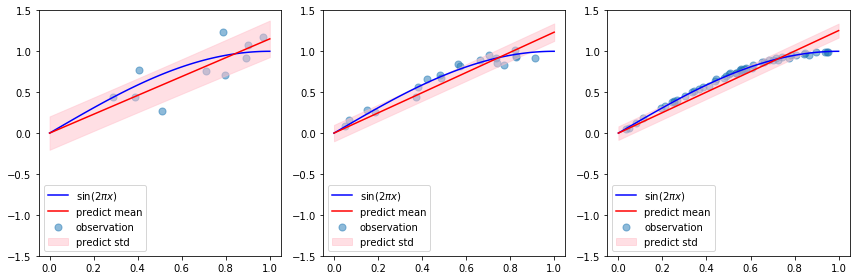

In [16]:
plot_regBayesien()

Vu qu'on a accès la loi de probabilité des points $\color{red}{\text{on à accès a une marge d'erreur}}$.

La zone rouge corrspond à la zone ou il y a 95% de chance que soit le bon $\theta$ (par rapport au données).

**Cas général (Sk-learn)**:

$$
P(y\mid X,\theta)= \mathcal{N}( (\omega,X)+b, \alpha)
$$

avec $\theta=(\omega,b)$ les paramètres du modèle et $\alpha$ l'a priori. Sur les poids on se donne un a priori Gaussien:

$$
P(\theta\mid \lambda)=\mathcal{N}( 0, \frac{1}{\lambda})
$$

On va donc construire:

$$
P(\theta \mid X_1,...X_n, y_1, ... y_n)
$$

On a $\color{red}{\text{deux paramètres libres $\alpha$ et $\lambda$}}$. Ils sont eux mêmes calculcés en maximisant la vraisemblance.

Dans Sk-learn $\lambda$ et $\alpha$ suivent des lois gamma, cela dépend de 4 paramètres $\lambda_1$, $\lambda_2$, $\alpha_1$ et $\alpha_2$ que l'ont prend souvent à $10^{-6}$. Les changer, change l'a-priori sur les hyper-paramètres.

**Code**: 

Soit $X, Y$ les jeux de données. $X$ est l'observable et $Y$ les labels.
    
```python    
clf = BayesianRidge(compute_score=True)
clf.fit(X, y)
print(cfl.coef_) ## renvoit les coefficients $\omega$,
print(cfl.intercept_) ## renvoit le coefficient $b$,
print(cfl.alpha_) ## renvoit l'hyper-paramètre $\alpha$,
print(cfl.lambda_) ## renvoit l'hyper-paramètre $\lambda$,

Y_pred=cfl.predit(X_test) ## renvoit le résultat y du modèle pour $X_{test}$ en entrée.
```

## Régression logistique

Une approche proche de ce qu'on a vu jusqu'à présent peut être utilisée pour faire de la $\color{red}{\text{classification}}$.

Si on prend un problème de classification à deux classes, on cherche à construire:

$$
y=f(X)+\epsilon
$$

avec $y\in [0,1]$. Si y est proche de zéro on est dans la classe A et sinon B.  D'un point de vue probabiliste, on cherche:

$$
y\approx \mathcal{B}(p)
$$
avec $\mathcal{B}(p)$ une loi de Bernoulli et

$$
P(X=A)=p, \quad P(X=B)=1-p.
$$ 

Comment construire $p$ ?

**Idée 1**:

$$
p=\frac{e^{f_{\theta}(X)}}{1+e^{f_{\theta}(X)}}, \quad 1-p= \frac{1}{1+e^{f_{\theta}(X)}}
$$

ca permet d'avoir $p \in [0,1]$. 

**Idée 2**: On choisit une modèle linéaire après.

$$
f_{\theta}(X)= \sum_{i=1}^d \omega_i x_i + b
$$

avec $X=(x_1,...,x_d)$.

**Note**: $\color{red}{\text{cela revient à trouver une droite/un plan qui sépare les données.}}$

**Comment on construit le modèle** ?

On définit aussi la $\color{red}{\text{vraisemblance}}$. Ensuite comme précédemment:

$\color{red}{\text{on cherche $\theta$ qui maximise la vraisemblance}}$.

Comme précédent, on peut se donner un a priori Gaussien (régularisation $l_2$) ou un a priori de Laplace (régularisation $l_1$).

In [20]:
import numpy as np
import matplotlib . pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

def plot_reglog(samples):
    centers = [[ -5, 0], [0, 2.5]]
    X, y = make_blobs(n_samples =samples, centers = centers, random_state =40)
    transformation = [[0.4 , 0.2] , [ -0.4 , 1.2]]
    X = np.dot (X, transformation)
    clf = LogisticRegression(solver='sag', max_iter =100).fit(X, y)

    h = .02 # step size in the mesh
    x_min , x_max = X[:, 0]. min () - 1, X[:, 0]. max () + 1
    y_min , y_max = X[:, 1]. min () - 1, X[:, 1]. max () + 1
    xm= np.arange (x_min , x_max , h)
    ym= np.arange (y_min , y_max , h).T
    xx , yy = np.meshgrid (xm ,ym)

    Z = clf.predict (np.c_[xx.ravel() , yy.ravel() ])
    Z = Z.reshape (xx.shape )
    
    plt.figure ()
    plt.contourf (xx , yy , Z, cmap = plt.cm.Accent)
    colors = 'bry'
    for i, color in zip (clf.classes_ , colors ):
        idx = np.where (y == i)
        plt.scatter (X[idx , 0],X[idx , 1],c=color,cmap =plt.cm.Paired,edgecolor ='black', s =30)

    xmin, xmax = plt . xlim ()
    lmin =( -( xmin * clf.coef_ [0 ,0]) - clf.intercept_ [0]) / clf.coef_ [0 ,1]
    lmax =( -( xmax * clf.coef_ [0 ,0]) - clf.intercept_ [0]) / clf.coef_ [0 ,1]
    plt.plot([ xmin,xmax], [lmin ,lmax ],ls = '--', color = color )

    plt.show()

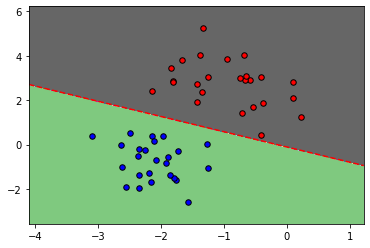

In [21]:
plot_reglog(50)

**Code**

Soit $X, Y$ les jeux de données. $X$ est l'observable et $Y$ les labels.

```python
# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(penaltly='l2',C=1e5)
logreg.fit(X, Y)
print(logreg.coef_) ## renvoit les coefficients $\omega$,
print(logreg.intercept_) ## renvoit le coefficient $b$,
print(logref.classes_) ## la liste des classes connues par le modèle

logreg.predict(X_test) ## prédit la classe de $X_{test}$
logreg.predict_proba(X_test) ## donne la probabilité d'appartenance à chaque classe de $X_{test}$
```

Ici $C$ est l'inverse du coefficient de régularisation (de notre a priori).

In [22]:
def plot_poly():
    centers = [[-5, 0], [0, 1.5], [5, -1], [0.5,-2.4]]
    X, y = make_blobs(n_samples=500, centers=centers, random_state=20)

    for multi_class in ('ovr','multinomial'):
        clf = LogisticRegression(solver='sag', max_iter=500, random_state=20,
                             multi_class=multi_class).fit(X, y)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.figure()
        plt.contourf(xx, yy, Z, cmap=plt.cm.Accent)

        colors = "bryc"
        for i, color in zip(clf.classes_, colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Accent,
                    edgecolor='black', s=20)
        
        xmin, xmax = plt.xlim()
        lmin=0.0; lmax=0.0
    
        for i, color in zip(clf.classes_, colors):
            lmin= (-(xmin * clf.coef_[i, 0]) - clf.intercept_[i]) / clf.coef_[i, 1]
            lmax= (-(xmax * clf.coef_[i, 0]) - clf.intercept_[i]) / clf.coef_[i, 1]
            plt.plot([xmin, xmax], [lmin, lmax],ls="--", color=color)
            plt.ylim(-5.5,4.7)
        
    plt.show()

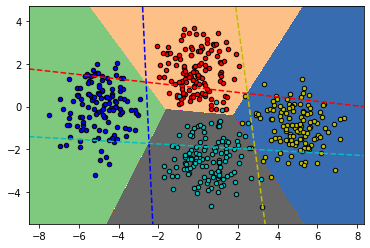

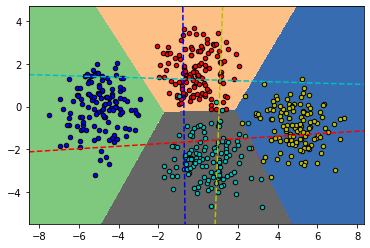

In [23]:
plot_poly()

## Régression à Noyau

On avait vu au premier semestre **la régression à noyau**.

**Idée**:

$$
f_{\theta}(x)=\sum_{i=1}^d \omega_i \phi(x_i), \quad\mbox{avec}\quad \phi(x)= \sum_{i=j}^n a_j k(x,x_j)
$$

On applique une transformation $\phi(x)$:
- qui permet de se ramener a un problème linéaire,
- cette transformation peut augmenter la dimension des données,
- elle est construite à partir des données et d'un noyau $k(x,y)$ (théorie difficile).

On peut appliquer cette théorie à: $\color{red}{\text{la régression bayesienne et la régression logistique}}$.

On parle de $\color{red}{\text{processus gaussien}}$.

Exemple régression:

http://www.infinitecuriosity.org/vizgp/#

**Code pour la régression**:

```Python
kernel = DotProduct() ### choix du noyau
## Autre choix ==> kernel= RBF, Matern, RationalQuadratic, ExpSineSquared etc 
gpr = GaussianProcessRegressor(kernel=kernel).fit(X, y)
gpr.score(X, y)
gpr.predict(X_test)
```

On peut sommer des noyaux:

```Python
kernel = DotProduct() + RBF()
```

Pour la classification

```Python
kernel = 1.0 * RBF(0.2)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X, y)
```

Comment la régression à noyau peut être utile pour la classification ?

In [24]:
def func1(z):
    return z/5.0 + 0.25*z/np.sqrt(z[0]*z[0]+z[1]*z[1])

def func2(z):
    return z/5.0 + z/np.sqrt(z[0]*z[0]+z[1]*z[1])

def transformation(x,y):
    return [x**2.0,y**2.0,np.sqrt(1.5*x*y+1.2)]

In [25]:
def plot_kernel_classfication():
    mean = [0, 0]
    cov = [[0.04, 0], [0, 0.04]] 
    X  = np.random.multivariate_normal(mean, cov, 200)
    Z= copy.copy(X)
    Z2= copy.copy(X)
    Z_add = np.zeros(200)
    Z2_add = np.zeros(200)
    for i in range(0,200):
        Z[i,:]=func1(X[i,:])
        Z2[i,:]=func2(X[i,:])
    
        TX,TY,TZ=transformation(Z[:,0],Z[:,1])
        TX2,TY2,TZ2=transformation(Z2[:,0],Z2[:,1])
    
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "bar"}, {"type": "scene"}]],
    ) 
    fig.add_trace(go.Scatter(x=Z[:, 0], y=Z[:, 1],
                               mode='markers',marker_size=5,marker_color='blue'), row=1, col=1 )
    fig.add_trace(go.Scatter(x=Z2[:, 0], y=Z2[:, 1],
                               mode='markers',marker_size=5,marker_color='red'), row=1, col=1 )
    fig.add_trace(go.Scatter3d(x=TX[:], y=TY[:], z=TZ[:],
                               mode='markers',marker_size=5,marker_color='blue'), row=1, col=2 )
    fig.add_trace(go.Scatter3d(x=TX2[:], y=TY2[:], z=TZ2[:],
                               mode='markers',marker_size=5,marker_color='red'), row=1, col=2 )
    fig.update_layout(showlegend=False)

    fig.show()

In [26]:
plot_kernel_classfication()

## Conclusion

- La régression linéaire permet de construire, pour toute dimension de x, des modèles approchant

$$
y=f(x)+ \epsilon
$$

à partir d'exemples $(x_1,...x_n)$ et $(y_1,...,y_n)$

- On peut construire une version probabiliste qui permet de donner une nouvelle interprétation à la régularisation.

- On peut la voir comme un a priori sur les poids qu'on se donne au début.

- La **régression Bayésienne** qui ne construit pas le meilleur modèle (meilleur poids) mais la distribution des poids et limite le sur apprentissage.

- La régression permet aussi de faire de la **classification**.

- La méthode de Noyau peut s'appliquer à ces méthodes pour passer au nonlinéaire.